# Exercises XP. Mini project

## Data preprocessing

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.data.path.append('/root/nltk_data')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from skopt import BayesSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import io

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving train.txt to train (1).txt


In [ ]:
for filename, content in uploaded.items():
    print(f'File {filename} was uploaded with length {len(content)} bytes')

columns = ['Text', 'Emotion']

df = pd.read_csv(io.StringIO(content.decode('utf-8')), sep=';', names=columns)

df.head()

File train (1).txt was uploaded with length 1658616 bytes


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     16000 non-null  object
 1   Emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


<ipython-input-5-34bcb20994cc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotion', data=df, palette='viridis')


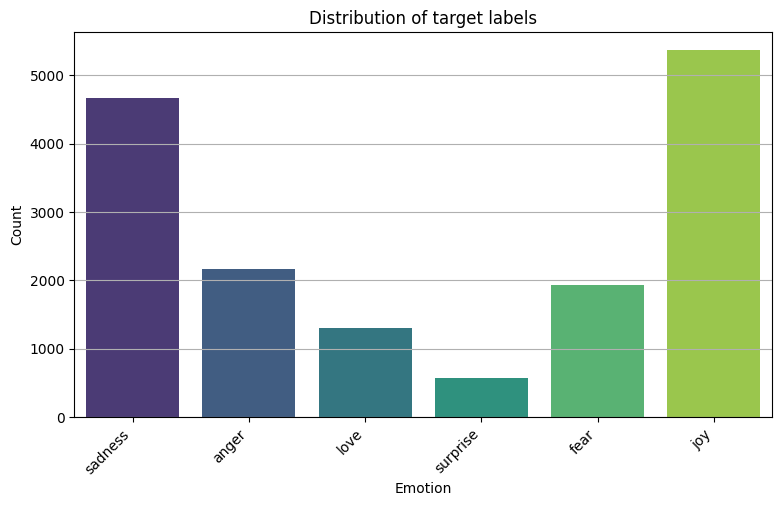

In [ ]:
# Plotting the distribution of target labels
plt.figure(figsize=(9, 5))
sns.countplot(x='Emotion', data=df, palette='viridis')
plt.grid(axis='y')
plt.title('Distribution of target labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Most emotions are "joy" and "sadness"

## Data preprocessing: removing any characters other than alphabetical, converting the string to lowercase, checking for stop words in the data and removing them, lemmatizing each word

In [ ]:
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = ''.join([char.lower() for char in text if char.isalpha() or char.isspace()])

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply the preprocessing function to the 'Text' column
df['Processed_Text'] = df['Text'].apply(preprocess_text)

print(df.head())

                                                Text  Emotion  \
0                            i didnt feel humiliated  sadness   
1  i can go from feeling so hopeless to so damned...  sadness   
2   im grabbing a minute to post i feel greedy wrong    anger   
3  i am ever feeling nostalgic about the fireplac...     love   
4                               i am feeling grouchy    anger   

                                      Processed_Text  
0                              didnt feel humiliated  
1  go feeling hopeless damned hopeful around some...  
2          im grabbing minute post feel greedy wrong  
3  ever feeling nostalgic fireplace know still pr...  
4                                    feeling grouchy  


## Random Forest Classifier

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Text'], df['Emotion'], test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test_vectorized)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')

print('\nClassification Report:\n', classification_report(y_test, predictions))


Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.90      0.87       427
        fear       0.85      0.85      0.85       397
         joy       0.90      0.92      0.91      1021
        love       0.84      0.76      0.80       296
     sadness       0.94      0.91      0.92       946
    surprise       0.74      0.78      0.76       113

    accuracy                           0.89      3200
   macro avg       0.85      0.85      0.85      3200
weighted avg       0.89      0.89      0.89      3200



## Tune the model hyperparameters using GridSearchCV, RandomSearchCV, and Bayesian optimization. Document the configurations and results of each method.
Hyperparameters: These are the configuration settings used to structure a machine learning model. They are not learned from the data but are set prior to the training process. Parameters: These are the internal variables that the model learns from the training data.

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_vectorized, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print("Best Hyperparameters (GridSearchCV):", best_params_grid)

# Evaluate the model with the best parameters on the test set
best_rf_model_grid = grid_search.best_estimator_
predictions_grid = best_rf_model_grid.predict(X_test_vectorized)
accuracy_grid = accuracy_score(y_test, predictions_grid)
print(f'Accuracy (GridSearchCV): {accuracy_grid:.2f}')

## RandomizedSearchCV:
Idea: Randomized search is a method that samples a specified number of hyperparameter combinations from the hyperparameter space.

In [10]:
# Define the parameter distributions
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model
random_search.fit(X_train_vectorized, y_train)

# Get the best parameters
best_params_random = random_search.best_params_
print("Best Hyperparameters (RandomizedSearchCV):", best_params_random)

# Evaluate the model with the best parameters on the test set
best_rf_model_random = random_search.best_estimator_
predictions_random = best_rf_model_random.predict(X_test_vectorized)
accuracy_random = accuracy_score(y_test, predictions_random)
print(f'Accuracy (RandomizedSearchCV): {accuracy_random:.2f}')

Best Hyperparameters (RandomizedSearchCV): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 132}
Accuracy (RandomizedSearchCV): 0.89


## Bayesian Optimization (BayesSearchCV)

In [ ]:
# Define the parameter search space
param_space = {
    'n_estimators': (50, 150),
    'max_depth': (1, 20),  # Adjusted to start from 1 instead of None
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}


# Initialize BayesSearchCV
bayesian_search = BayesSearchCV(rf_classifier, param_space, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the model
bayesian_search.fit(X_train_vectorized, y_train) # in this raw gives me an error , i don't know why. So i decided do not to use this method.

# Get the best parameters
best_params_bayesian = bayesian_search.best_params_
print("Best Hyperparameters (Bayesian Optimization):", best_params_bayesian)

# Evaluate the model with the best parameters on the test set
best_rf_model_bayesian = bayesian_search.best_estimator_
predictions_bayesian = best_rf_model_bayesian.predict(X_test_vectorized)
accuracy_bayesian = accuracy_score(y_test, predictions_bayesian)
print(f'Accuracy (Bayesian Optimization): {accuracy_bayesian:.2f}')

In [ ]:
uploaded = files.upload()

In [ ]:
for filename, content in uploaded.items():
    print(f'File {filename} was uploaded with length {len(content)} bytes')

columns = ['Text', 'Emotion']

df1 = pd.read_csv(io.StringIO(content.decode('utf-8')), sep=';', names=columns)

df1.head()

In [ ]:
# Preprocess the test data
df1['Processed_Text'] = df1['Text'].apply(preprocess_text)

df1.head()

## Evaluate the model on test data using Accuracy Score, Precision Score, Recall Score, and Confusion Matrix. Create a ROC curve for visual evaluation.

In [ ]:
# Vectorize the test data using the same vectorizer as the one used for training
X_test_vectorized = vectorizer.transform(df1['Processed_Text'])

# Make predictions on the test set
predictions = rf_classifier.predict(X_test_vectorized)

# Evaluate the performance
accuracy = accuracy_score(df1['Emotion'], predictions)
precision = precision_score(df1['Emotion'], predictions, average='weighted')
recall = recall_score(df1['Emotion'], predictions, average='weighted')
conf_matrix = confusion_matrix(df1['Emotion'], predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 89% - The proportion of correctly classified instances among the total instances. Precision: 89.10% - The precision is a measure of the accuracy of the positive predictions. Recall: 89.00% -  sensitivity or true positive rate, is the proportion of actual positive instances that were correctly predicted.

In [ ]:
# Get predicted probabilities for each class
y_score = rf_classifier.predict_proba(X_test_vectorized)

# Binarize the true labels
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_test_bin = label_binarize(df1['Emotion'], classes=rf_classifier.classes_)

# Initialize variables for ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(len(rf_classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(rf_classifier.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {rf_classifier.classes_[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Having an AUC-ROC of 0.99 for each emotion suggests that model performs exceptionally well, almost achieving perfect separation for each class. The ROC curves for each class are concentrated in the top-left corner means that model has a high true positive rate and a low false positive rate across different thresholds. This is indicative of a well-performing model that effectively discriminates between different emotions.

In [11]:
# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Method': ['GridSearchCV', 'RandomizedSearchCV'],
    'Best Hyperparameters': [best_params_grid, best_params_random],
    'Accuracy': [accuracy_grid, accuracy_random],
})

print(results_df)

               Method                               Best Hyperparameters  \
0        GridSearchCV  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   
1  RandomizedSearchCV  {'max_depth': None, 'min_samples_leaf': 1, 'mi...   

   Accuracy  
0  0.887813  
1  0.888750  


Both GridSearchCV and RandomizedSearchCV hyperparameter tuning methods yield similar performance for RandomForestClassifier. GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150} RandomizedSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 132} Given the similarity in performance and the hyperparameters chosen, it might be challenging to conclusively say that one method is significantly better than the other in this particular case. Both methods seem to have found hyperparameters that result in a RandomForestClassifier with similar accuracy. Effectiveness of hyperparameter tuning methods can vary depending on the specific characteristics of the dataset and the model. In some cases, one method might outperform the other, but in your case, the difference is subtle.